Choose the time series and apply {\bf sequential LSTM} (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/). Compare and contrast between the three techniques applied.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [4]:
df = pd.read_csv("./ParisIndex-2016-2023.csv",index_col=0)
#Primero transformamos el dataframe a un formato más cómodo en el que los índices de los valores son las fechas
df = df.T
#Posteriormente transformamos los índices a formato 'date-time' ya que originalmente son de tipo 'Object'
df.index = pd.to_datetime(df.index)
#vemos como quedó nuestro dataframe
df.head(5)

,Close
2016-01-04,4522.450195
2016-01-05,4537.629883
2016-01-06,4480.470215
2016-01-07,4403.580078
2016-01-08,4333.759766


We take the time series of the first stock

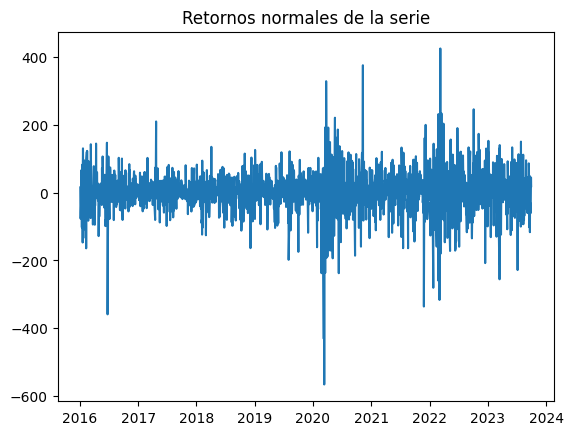

In [5]:
raw_seq = df
#xs = np.arange(len(raw_seq)-1)
raw_seq = raw_seq.diff().dropna() #normal returns
plt.plot(raw_seq)
plt.title("Retornos normales de la serie")
plt.show()

Divide the time series in train and test

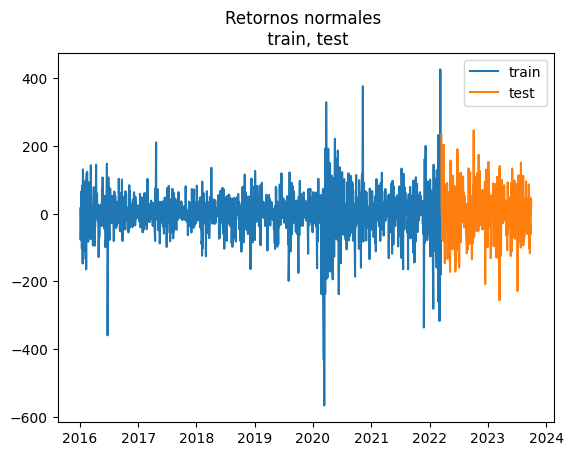

In [6]:
#Función para dividir el dataframe en datos de entrenamiento y prueba
def train_test(df,p=90): #p- pocentaje de datos de entrenamiento
    l=len(df)
    div=int(np.ceil(p*l/100))
    df_train = df.iloc[:div]
    df_test = df.iloc[div:]
    return df_train, df_test


train_data, test_data = train_test(raw_seq,80)

plt.plot(train_data,label = "train")
plt.plot(test_data,label="test")
plt.title("Retornos normales \n train, test")
plt.legend()
plt.show()

Function to split the univariate sequence into sequences of n_steps elements

In [7]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return(array(X), array(y))

In [8]:
n_steps = 5
# split into samples
X, y = split_sequence(np.array(train_data), n_steps)
# summarize the data
for i in range(10):
    print(np.round(X[i],3), np.round(y[i],3))

[[ 15.18]
 [-57.16]
 [-76.89]
 [-69.82]
 [-21.02]] [66.01]
[[-57.16]
 [-76.89]
 [-69.82]
 [-21.02]
 [ 66.01]] [13.19]
[[-76.89]
 [-69.82]
 [-21.02]
 [ 66.01]
 [ 13.19]] [-79.05]
[[-69.82]
 [-21.02]
 [ 66.01]
 [ 13.19]
 [-79.05]] [-102.73]
[[ -21.02]
 [  66.01]
 [  13.19]
 [ -79.05]
 [-102.73]] [-20.59]
[[  66.01]
 [  13.19]
 [ -79.05]
 [-102.73]
 [ -20.59]] [82.69]
[[  13.19]
 [ -79.05]
 [-102.73]
 [ -20.59]
 [  82.69]] [-147.31]
[[ -79.05]
 [-102.73]
 [ -20.59]
 [  82.69]
 [-147.31]] [81.45]
[[-102.73]
 [ -20.59]
 [  82.69]
 [-147.31]
 [  81.45]] [130.29]
[[ -20.59]
 [  82.69]
 [-147.31]
 [  81.45]
 [ 130.29]] [-25.36]


In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
#We are working with a univariate series, so the number of features is one,
#for one variable.
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
# define model
model = Sequential()
#Input layer
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
#Hidden layers
model.add(Dense(1))
#output layer
model.compile(optimizer='adam', loss='mse')

In [15]:
# fit the model
model.fit(X, y, epochs=100,
          #verbose=0
          )  #epochs : between 20 and 50

Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 366.4131
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 386.4574
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 610.0662
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 679.5475
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 632.6279
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 721.1145
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 943.7933
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 938.8234
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 748.3570
Epoch 10/100
50/50 [==============================] - 0s 3ms/step - loss: 598.6194
Epoch 11/100
50/50 [==============================] - 0s 3ms/step - loss: 584.5361
Epoch 12/100
50/50 [==============================] - 0s 3ms/step - loss: 487.0625
Epoch 13/100


Now we apply the model to the data we have. To do it, we begin with the last 3 elements of the train data and use them to predict a new element. Then, we use this new element and the two before it to predict a new one. We repeat this until we predict the same number of elements as we have in the test set

In [16]:
# Define an array to save the predictions
prediction = []
#Take the last 3 elements of the train data
seq = train_data[-n_steps:]
#Shape them as we need to make a prediction using the model
seq = np.array(seq).reshape((1, n_steps, n_features))

#For the amount of elements in the test data:
for i in range(len(test_data)):
    # We reshape the sequence to the form we need to use the model
    seq = np.array(seq).reshape((1, n_steps, n_features))

    #Predict the next element and add it to the predicitons
    yhat = model.predict(seq, verbose=0)[0][0]
    prediction.append(yhat)

    #Update the sequence by using the prediction
    #and the last two/four elements before it
    seq = [seq[0][1][0], seq[0][2][0], seq[0][3][0], seq[0][4][0], yhat]
prediction = pd.DataFrame(data= prediction)
prediction.index = test_data.index

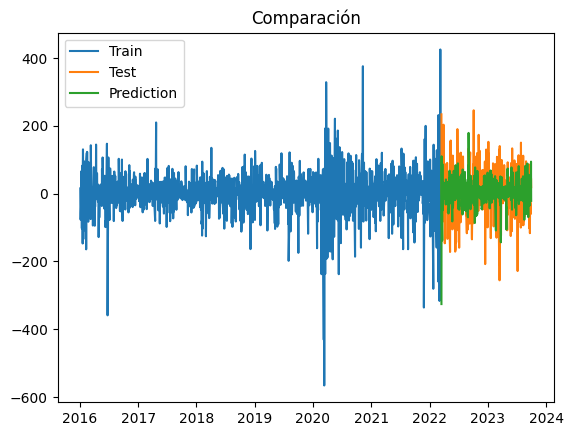

In [17]:
#Plot the results
plt.plot(train_data,label="Train")
plt.plot(test_data, label="Test")
plt.plot(prediction, label="Prediction")
plt.title("Comparación")
plt.legend()
plt.show()

WE can zoom in to see the predictions better

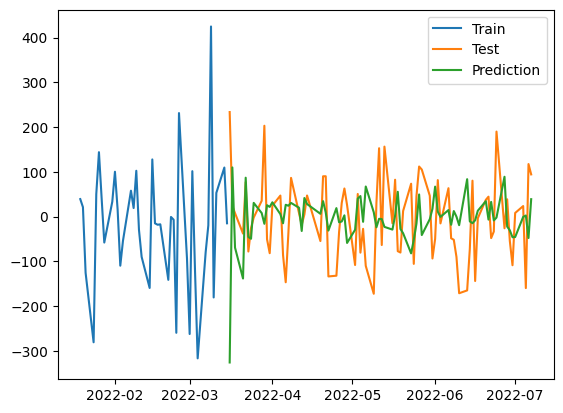

In [18]:
plt.plot(train_data[-40:],label="Train")
plt.plot(test_data[:80], label="Test")
plt.plot(prediction[:80], label="Prediction")
plt.legend()
plt.show()

LSTM works better than GARCH and ARIMA for financial market time series forecasting.